In [61]:
# 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [62]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from google.colab import files
import io

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('font', family='NanumBarunGothic') 
mpl.rc('axes', unicode_minus=False)
warnings.filterwarnings("ignore")

In [63]:
# 데이터셋 불러오기
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['vgames2.csv']))

Saving vgames2.csv to vgames2 (3).csv


In [64]:
# 데이터셋 둘러보기
print('\n null: \n ', df.isnull().sum()) # 결측치
print('-------------------------------')
print('\n type: \n ', df.dtypes) # 데이터 타입
print('-------------------------------')
print('\n shape: \n ', df.shape) # 데이터 모양


 null: 
  Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      2
dtype: int64
-------------------------------

 type: 
  Unnamed: 0      int64
Name           object
Platform       object
Year           object
Genre          object
Publisher      object
NA_Sales       object
EU_Sales       object
JP_Sales       object
Other_Sales    object
dtype: object
-------------------------------

 shape: 
  (16598, 10)


In [65]:
# --<전처리>--
# --------------------------------------------------------
#
# ㅇ 목표1: unname 행 없애기
#
# ㅇ 목표2: 매출액 형변환 하기(object -> float)
#
# ㅇ 목표3: other_sales 결측치 처리 결정
#  - imputation
#  - 7597: 2010 adventure 평균
#  - 16192: 2007 adventure 평균 
#
# ㅇ 목표4: year 형변환 및 NaN값 처리(0)
#  - NaN값 처리: 0
#
# --------------------------------------------------------

# 1. unname 행 없애기
df_new = df.drop(columns = 'Unnamed: 0')


# 2. 매출액 형변환
# 2-1: M 제거
# 2-2: K 분리, 형변환, 숫자 단위 변경

def del_KM(list):

    for a_list in list:

        # 2-1. M 제거
        df_new[a_list] = df_new[a_list].str.replace('M','')
        # df.replace('(.*)M(.*)', '', regex=True)


        # 2-2. K 분리, 형변환 및 숫자 단위 변경
        ## K 분리하기
        temp_df = df_new[a_list].str.split('K', expand = True)  # 행 0, 행 1

        ## 0번 행, 숫자로 형변환 하기
        temp_df_float = temp_df[0].apply(pd.to_numeric)

        ## K 있는 열만 *10^-3 하기
        result = np.where(temp_df[1] == '', temp_df_float * 0.001, temp_df_float)
           
        ## 붙이기
        df_new[a_list] = result

col_sales = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
del_KM(col_sales)


# 3. other_sales 결측치 처리
# 3-1. other_sales 비중 산출하기
rest_sales_list = ['NA_Sales', 'EU_Sales', 'JP_Sales']
total_sales_except_other = df_new[rest_sales_list].sum().sum()  # 8118.10
other_sales_total = df_new['Other_Sales'].sum()                 # 797.76

ratio_other_sales = other_sales_total / total_sales_except_other
# print('ratio of other sales is ', ratio_other_sales)

# 3-2. 결측치 처리하기
nan_list = [7596, 16191]   # df_new[df_new['Publisher'].isnull()] 사용해서 index 가져오기
for a_nan_list in nan_list:
    fill_number = df_new.loc[a_nan_list, ['NA_Sales', 'EU_Sales', 'JP_Sales']].sum() * ratio_other_sales
    df_new.loc[a_nan_list,'Other_Sales'] = fill_number


# 4. year 행 형변환 
df_new['Year'] = pd.to_numeric(df_new['Year'], errors = 'coerce').fillna(0)

# 5. 기타
# 5-1. Platform
df_new['Platform'] = np.where(df_new['Platform'] == '2010', '99', df_new['Platform'])
df_new['Platform'] = np.where(df_new['Platform'] == '2007', '99', df_new['Platform'])

# 5-2. Genre
df_new['Genre'].fillna('99', inplace = True)

# 5-3. Publisher
df_new['Publisher'].fillna('99', inplace = True)

# 전처리 결과
# --------------------------------------------------------
#
# ㅇ 변수명: df_new
# ㅇ 형태: float64(5), object(4)
# ㅇ 기억 필수
#  - Platform: 결측치 존재(2010, 2007 / 2개) --> '99'로 변경
#  - Genre: 결측치 존재(NaN/ 50개) --> '99'로 변경
#  - Publisher: 결측치 존재(NaN/ 58개) --> '99'로 변경
# --------------------------------------------------------
print(df_new.isnull().sum())

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64


In [66]:
# --<분석>--
# --------------------------------------------------------
#
# ㅇ 목표1: 지역
#  - (그래프1) 연도별 전체 게임 시장 크기 변화
#  - (그래프2) 최근 5년간, 지역별 게임 시장 크기 변화
#  - (통계/필수) 지역에 따라서 선호하는 게임 장르 다른지 조사 
#
# ㅇ 목표2: 개임 종류(Genre)
#  - (그래프1/필수) 연도별 게임의 트렌드 변화
#   == 최근 5년간 장르별 총 매출액 변화(가로 막대 비율 그래프)
#
# ㅇ 목표3: platform 종류
#  - (그래프1/필수) 매출이 높은 게임에 대한 분석
#   == 최근 5년간 platform별 총 매출액 변화 그래프화
#
# --------------------------------------------------------

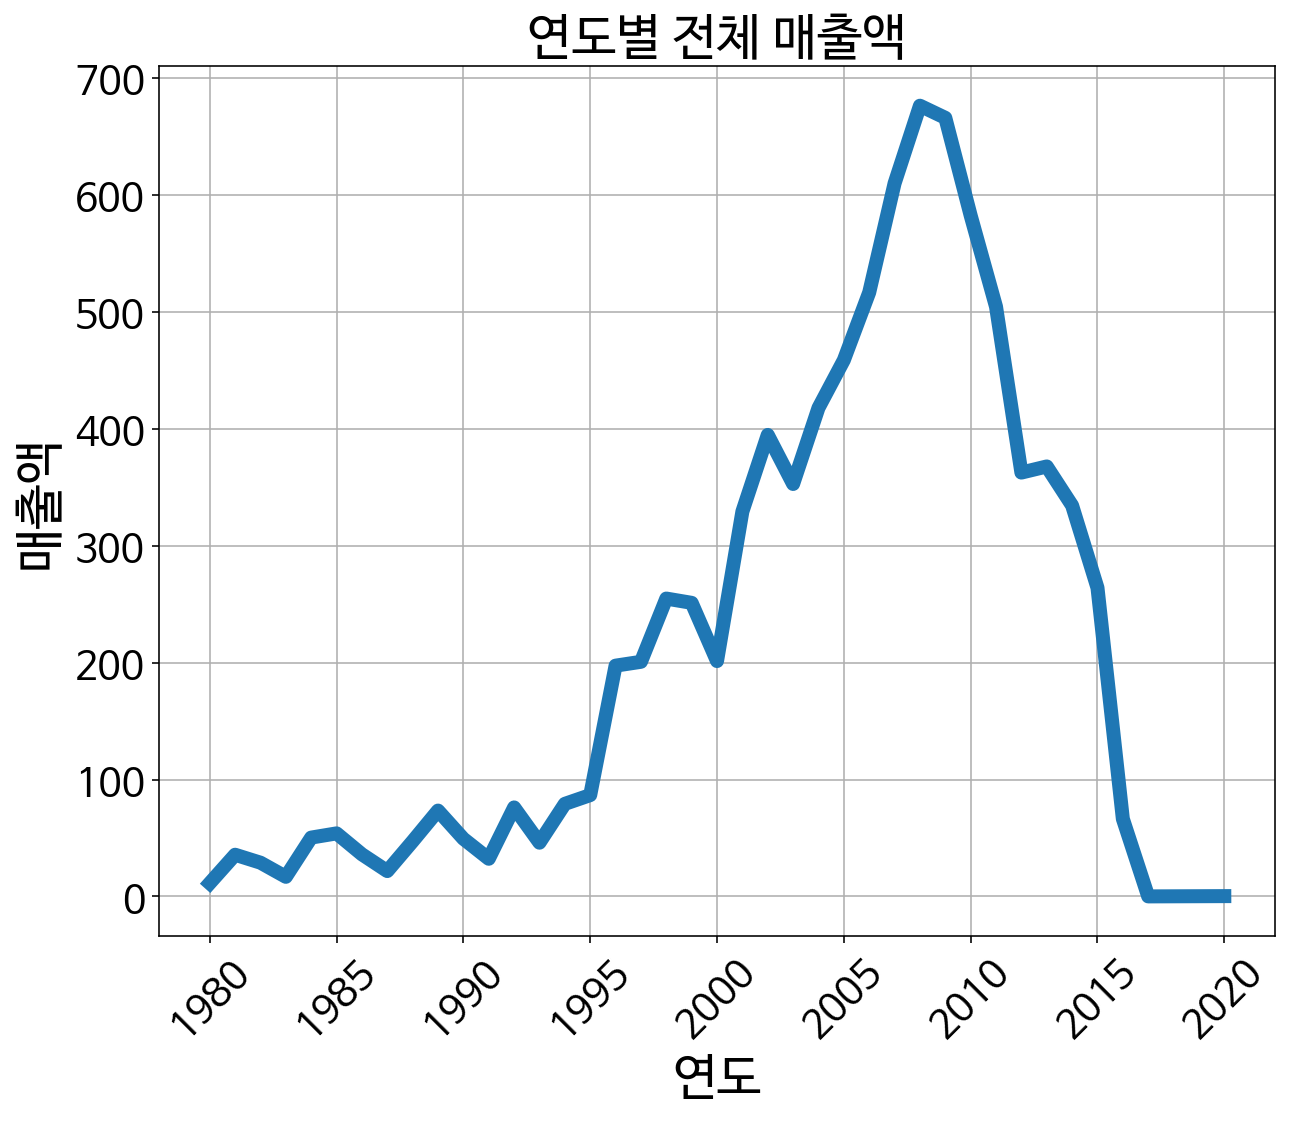

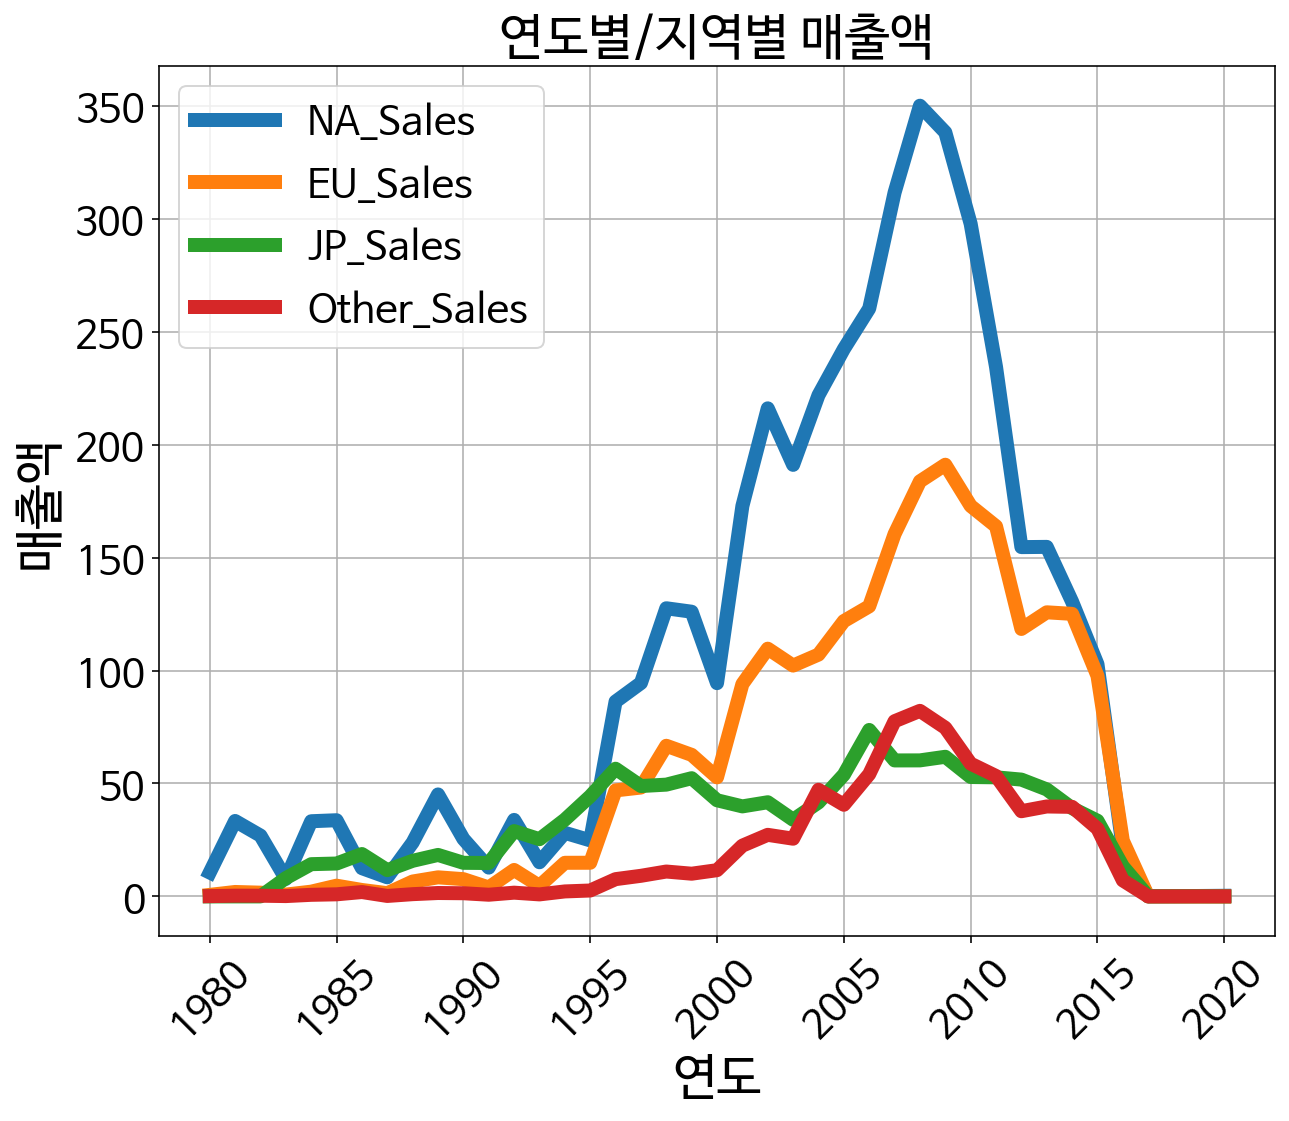

In [67]:
# --------------------------------------------------------
#
# ㅇ 목표1: 지역
#  - (그래프1) 연도별 전체 게임 시장 크기 변화
#  - (그래프2) 최근 5년간, 지역별 게임 시장 크기 변화
#  - (통계/필수) 지역에 따라서 선호하는 게임 장르 다른지 조사 
#   = 지역별 게임 장르의 평균 비교(ANOVA 사용)
#  
# --------------------------------------------------------

# 1-1. 표 만들기
data_graph_list = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

data_graph_NA_Sales = df_new.groupby('Year').NA_Sales.sum()
data_graph_EU_Sales = df_new.groupby('Year').EU_Sales.sum()
data_graph_JP_Sales = df_new.groupby('Year').JP_Sales.sum()
data_graph_Other_Sales = df_new.groupby('Year').Other_Sales.sum()

data_graph_concat = pd.concat([data_graph_NA_Sales, data_graph_EU_Sales,
                               data_graph_JP_Sales, data_graph_Other_Sales], axis = 1)

data_graph_concat['total'] = data_graph_concat.sum(axis = 1)
# print(data_graph_concat['total'])

data_graph_concat.reset_index(inplace=True)
data_graph_concat = data_graph_concat[data_graph_concat['Year'] >= 1980]
# data_graph_concat['Year'] = np.where(data_graph_concat['Year'] <= 2000, '', data_graph_concat['Year'])

# 1-2. 그래프 제작하기
# 주의: 결측치 제외

# 1-2-1. 연도별 전체 매출액
plt.figure(figsize = [10,8])
plt.plot(data_graph_concat['Year'], data_graph_concat['total'], linewidth = 7)  

plt.title('연도별 전체 매출액', fontsize = 25)
plt.xlabel('연도', fontsize = 25)
plt.ylabel('매출액', fontsize = 25)
plt.xticks(fontsize = 20, rotation = 45)
plt.yticks(fontsize = 20)

plt.grid()
plt.show()

# 1-2-2. 연도별/지역별 전체 매출액
plt.figure(figsize = [10,8])
for a in data_graph_list:
    plt.plot(data_graph_concat['Year'], data_graph_concat[a], label=a, linewidth = 7)  

plt.legend()
plt.title('연도별/지역별 매출액', fontsize = 25)
plt.xlabel('연도', fontsize = 25)
plt.ylabel('매출액', fontsize = 25)
plt.xticks(fontsize = 20, rotation = 45)
plt.yticks(fontsize = 20)

plt.legend(fontsize = 20)
plt.grid()
plt.show()


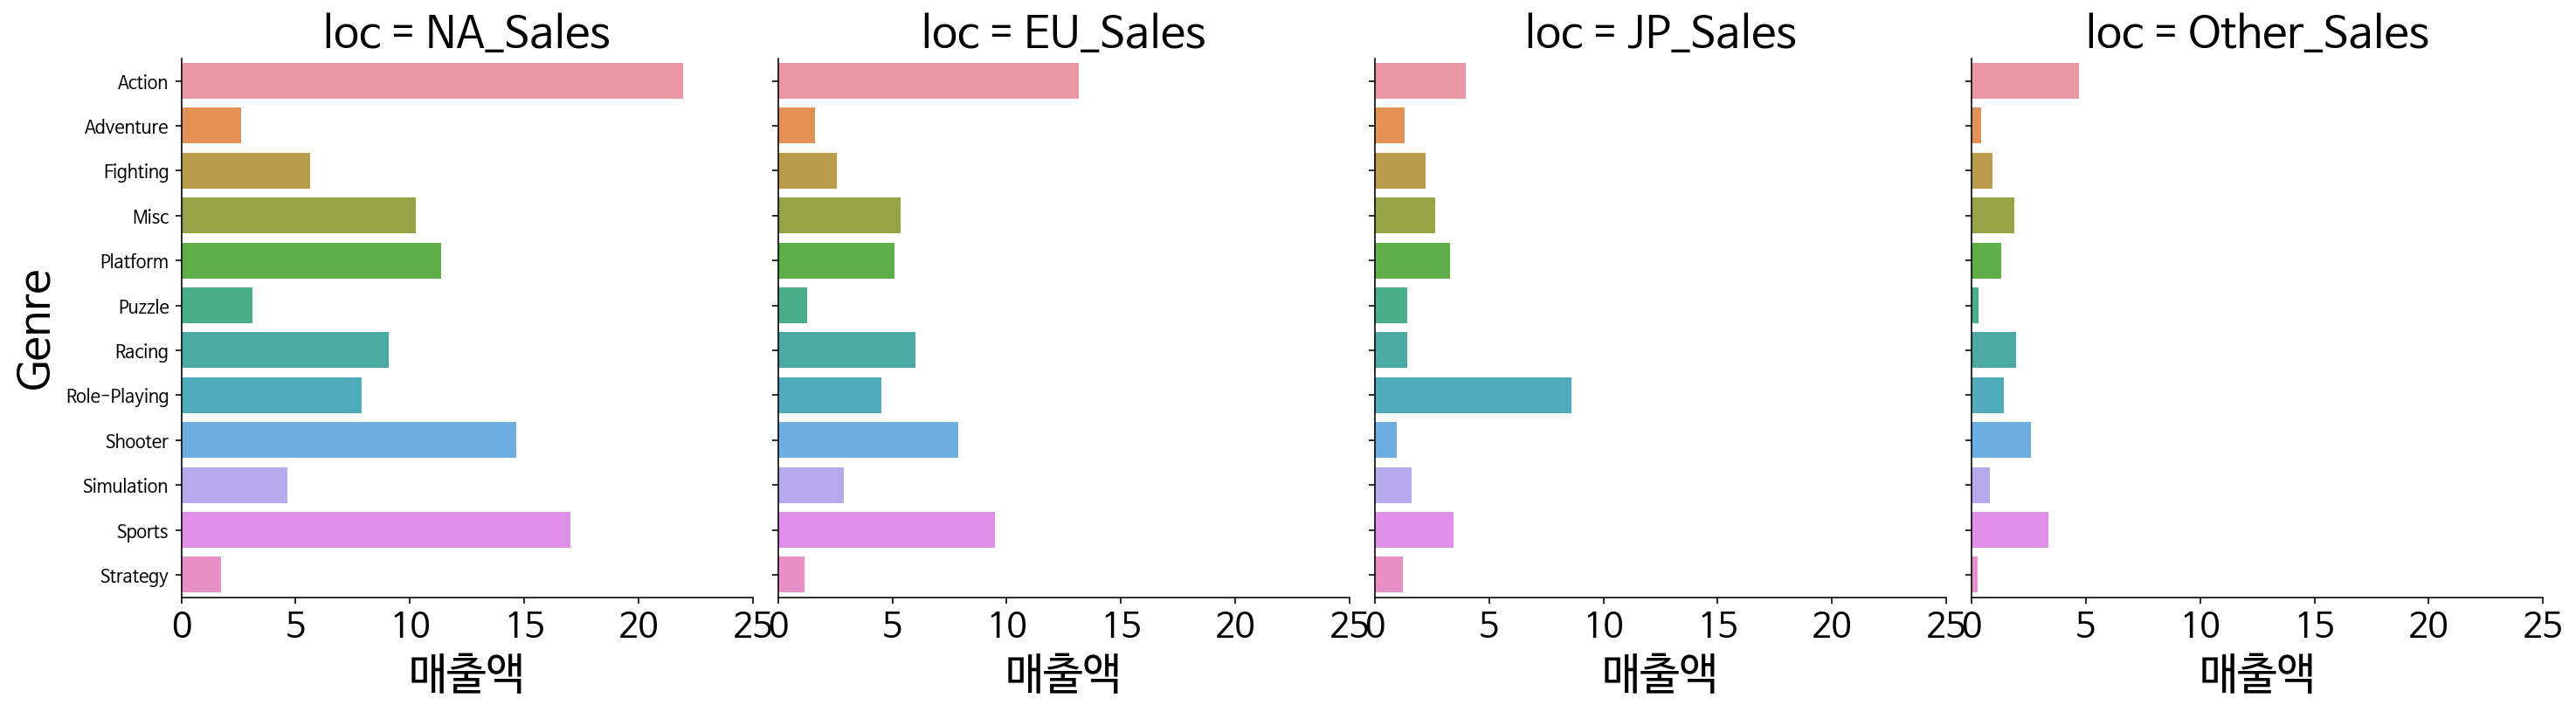

In [68]:
# 1-2. 지역에 따라서 선호하는 게임 장르 다른지 조사
# 1-2-1. 지역별/게임장르별 평균 매출액 표 만들기(대충 훑어보기용)
# 주의: 결측치 제외(year, genre)

df_loc_gen = df_new[df_new['Year'] >= 1980].groupby('Genre').sum()
df_loc_gen = df_loc_gen.drop(columns = 'Year').reset_index()
df_loc_gen = df_loc_gen[df_loc_gen['Genre'] != '99']
df_loc_gen_genre = df_loc_gen['Genre']

# 연도 및 장르 unique 구하기
unique_year = df_new[df_new['Year'] >= 1980]['Year'].unique()
unique_year_length = len(unique_year)
unique_genre = df_loc_gen['Genre'].unique()  # 39, 1980 이후 연도 / 최초의 df_loc_gen 의 genre 행과 순서 동일함

# 평균 매출액 표
df_loc_gen.drop(columns='Genre', inplace=True)
df_mean = df_loc_gen / unique_year_length 

df_loc_gen_mean = pd.concat([df_loc_gen_genre, df_mean], axis = 1) 

df_loc_gen_mean = df_loc_gen_mean.set_index('Genre').T
df_loc_gen_mean = df_loc_gen_mean.reset_index() # 순서: ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# 1-2-2. facet 그래프 만들기(가로 bar 그래프)
# 1-2-2-1. 라이브러리 불러오기
import seaborn as sns

# 1-2-2-2. tidy table 만들기
df_loc_gen_mean_tidy = df_loc_gen_mean.melt(id_vars='index', value_vars=unique_genre)
df_loc_gen_mean_tidy.columns = ['loc', 'Genre','value']
df_loc_gen_mean_tidy

# 1-2-2-3. 그래프 그리기
g = sns.catplot(x = 'value', y = 'Genre', col='loc', col_wrap=4, 
                data=df_loc_gen_mean_tidy, kind='bar', orient = 'h');
g.set_xlabels('매출액', fontsize = 25);
g.set_ylabels(fontsize = 25);
g.set_xticklabels(fontsize = 20);
g.set_titles(size = 25);

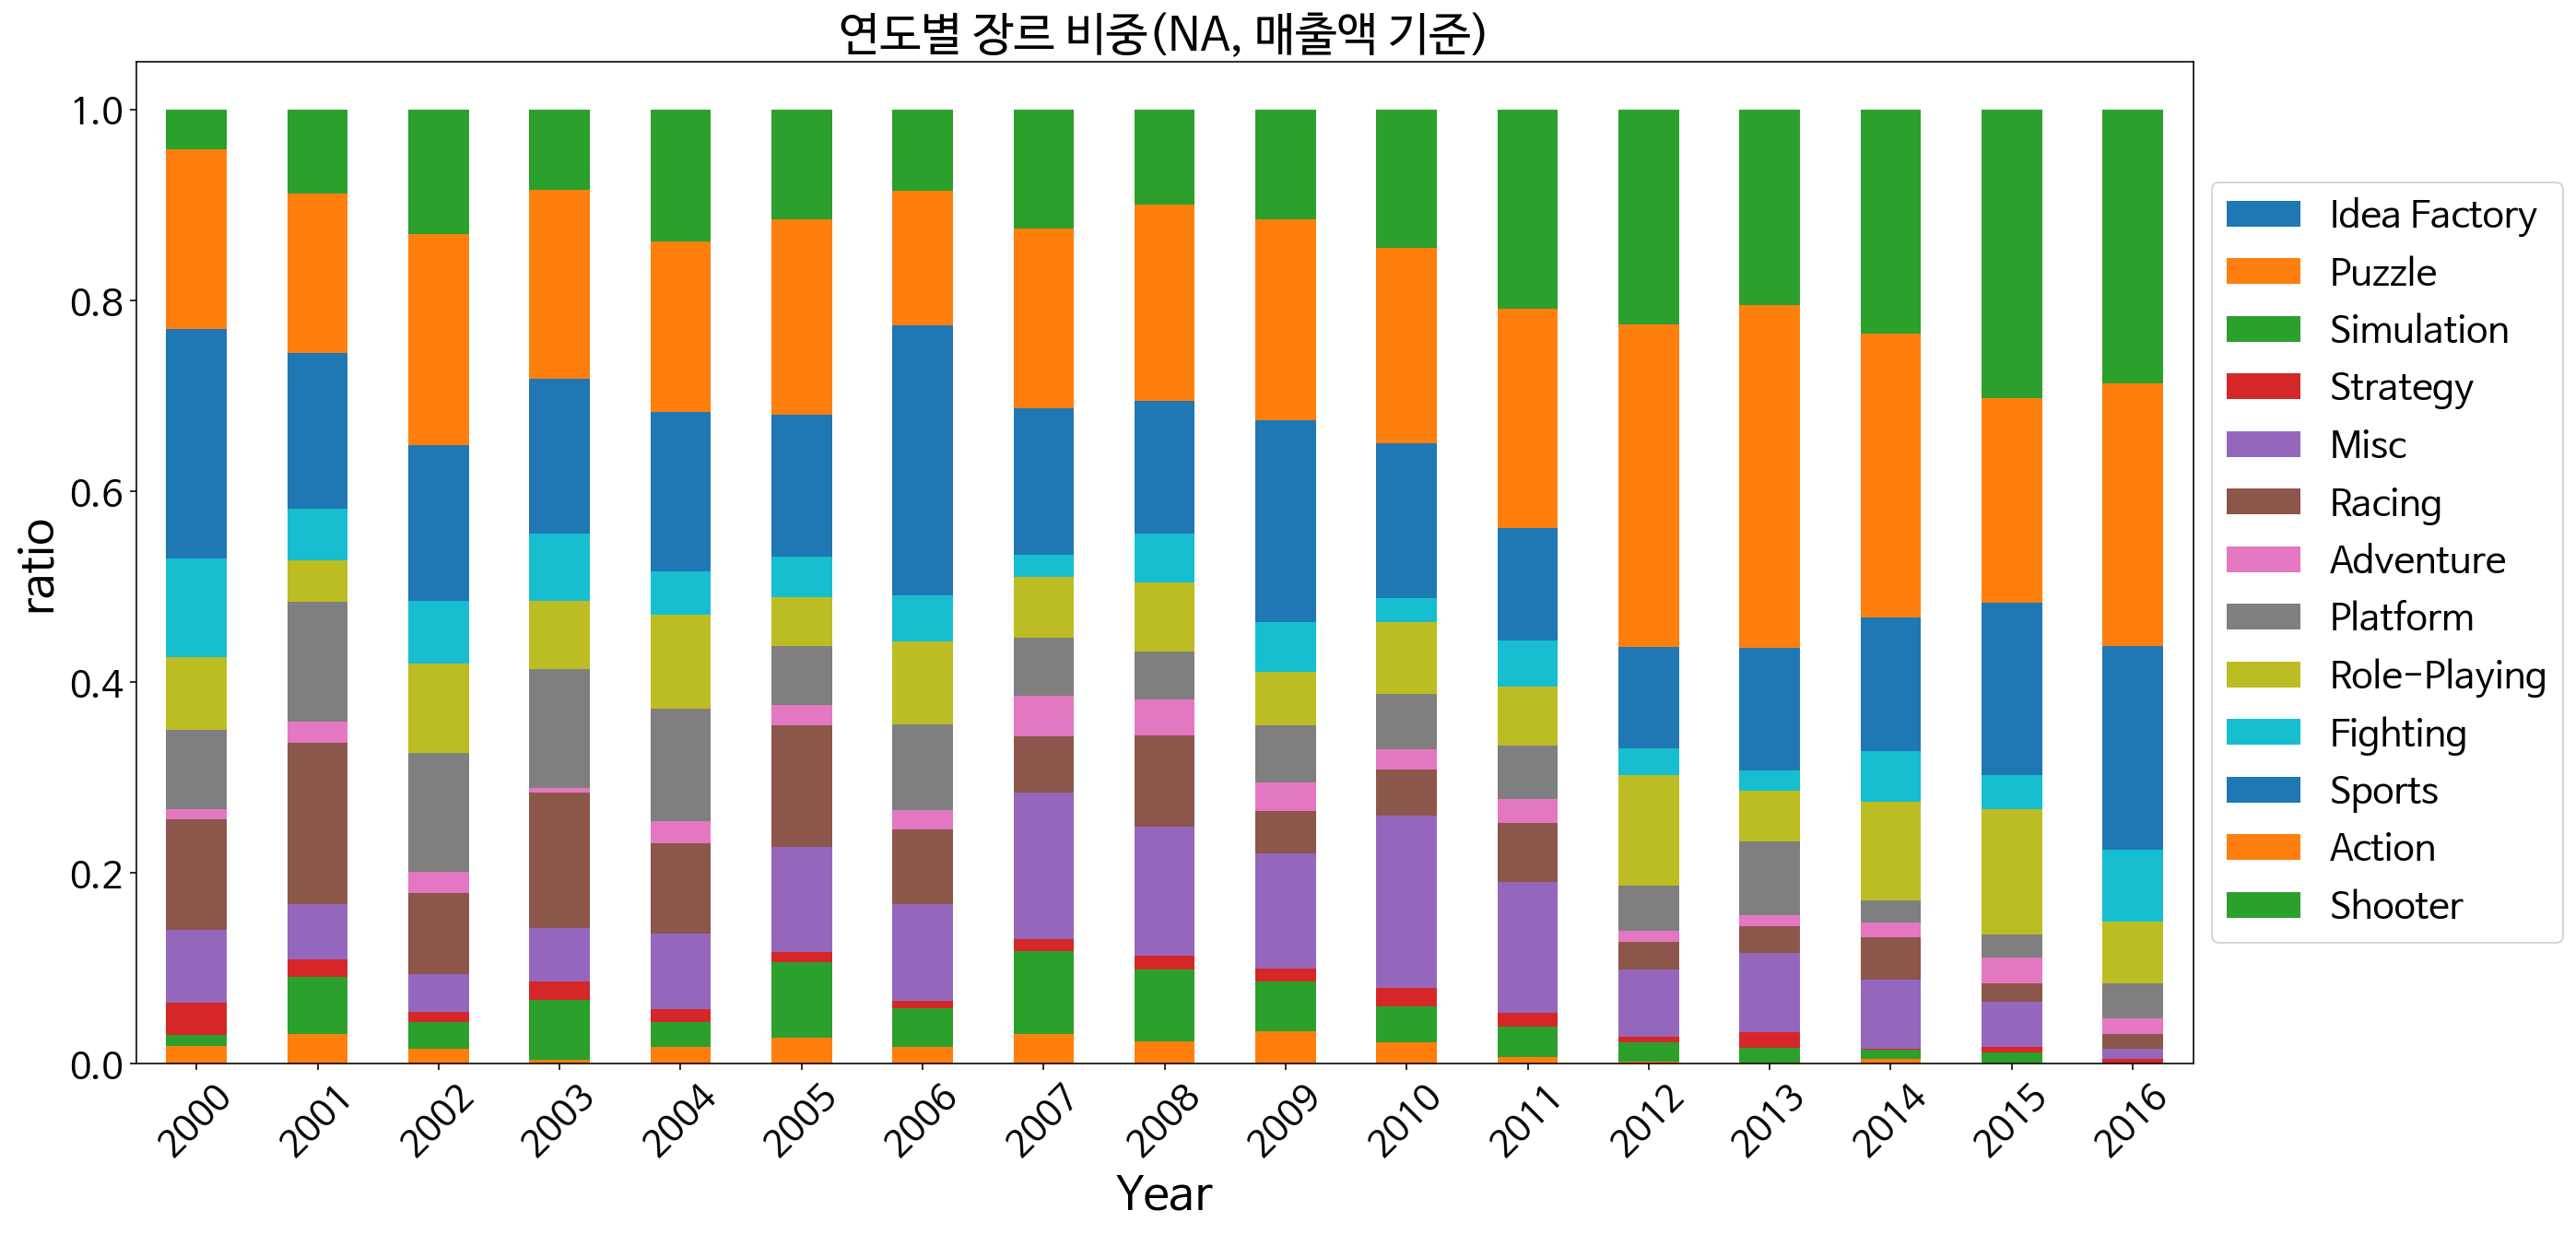

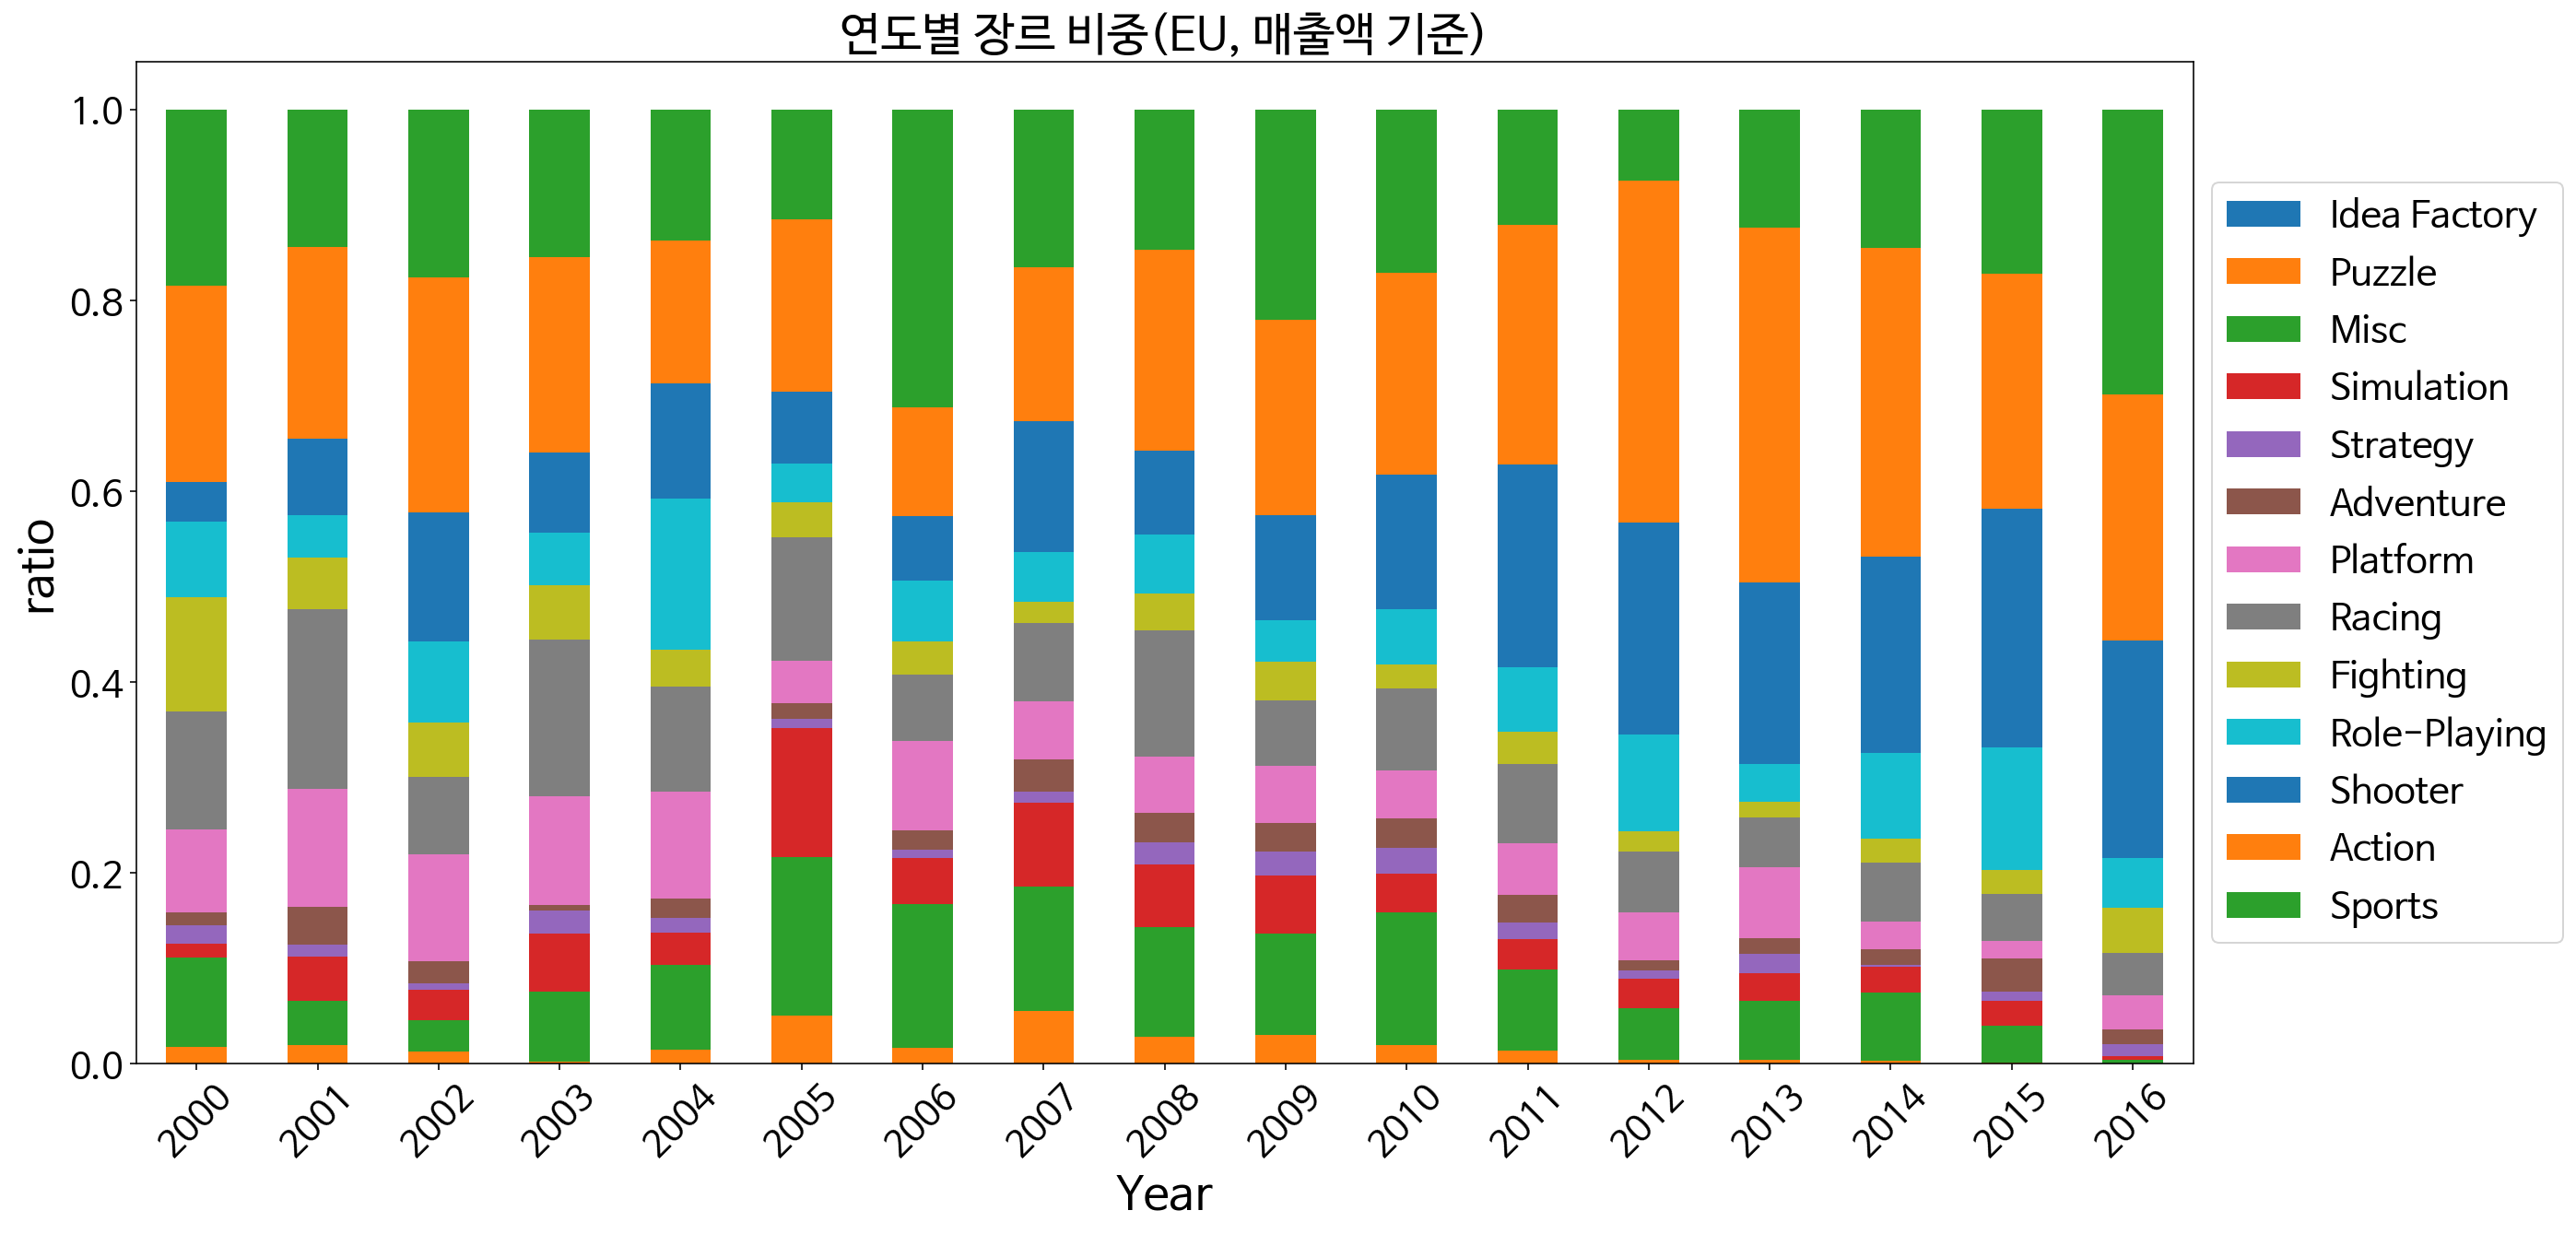

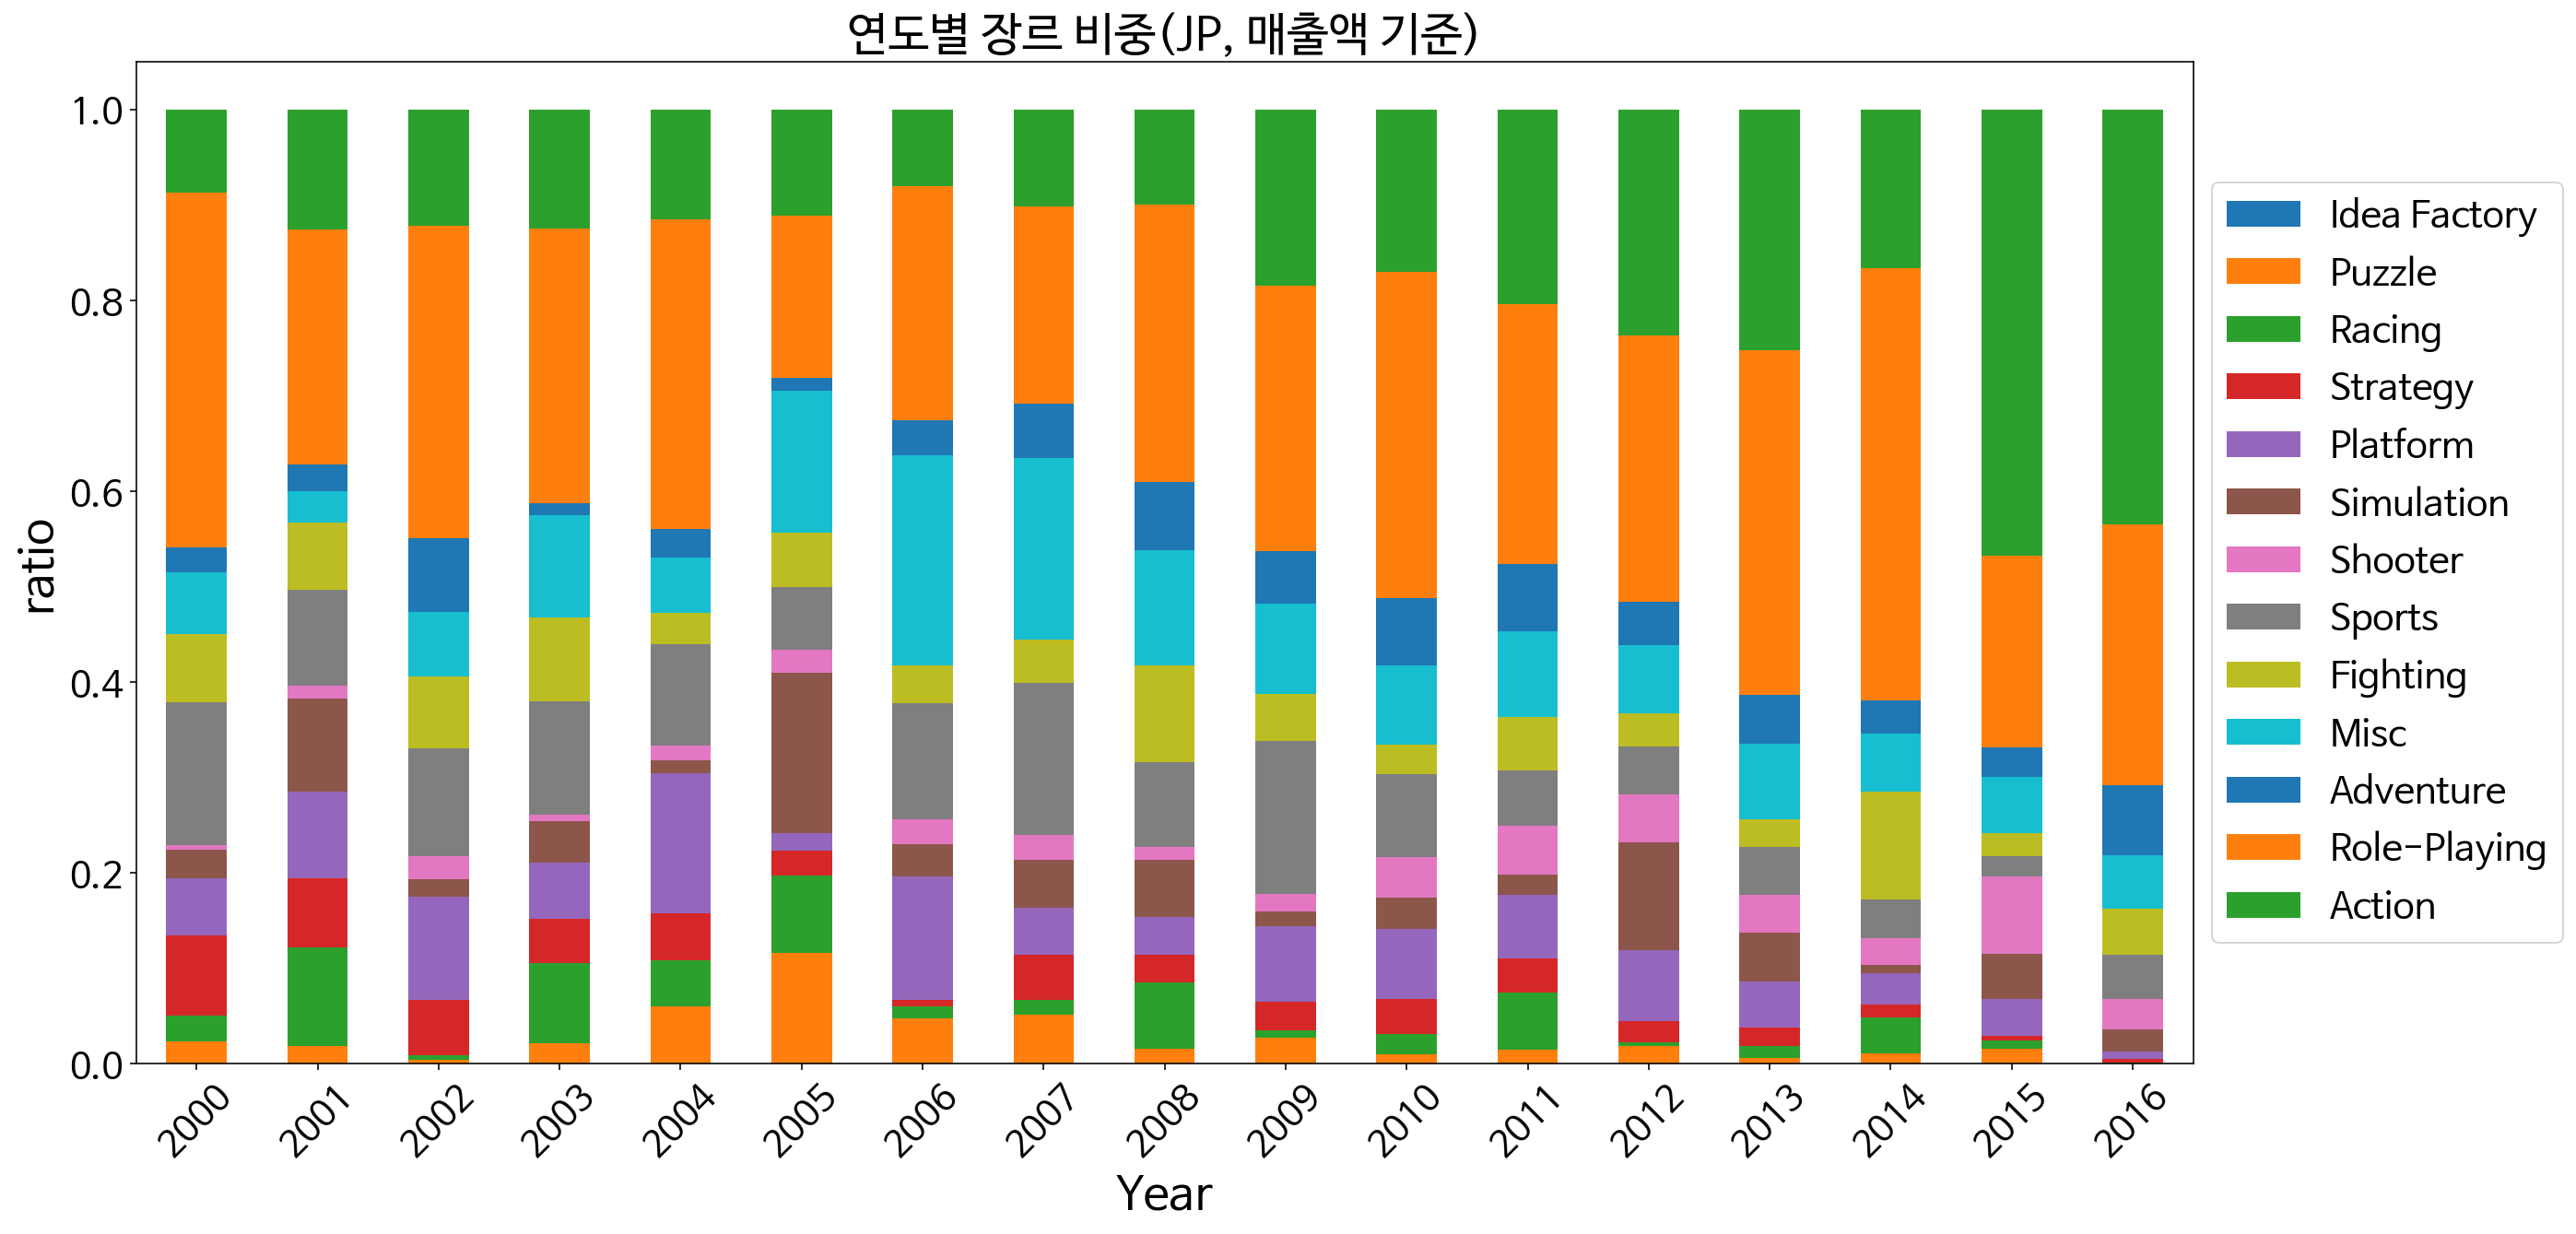

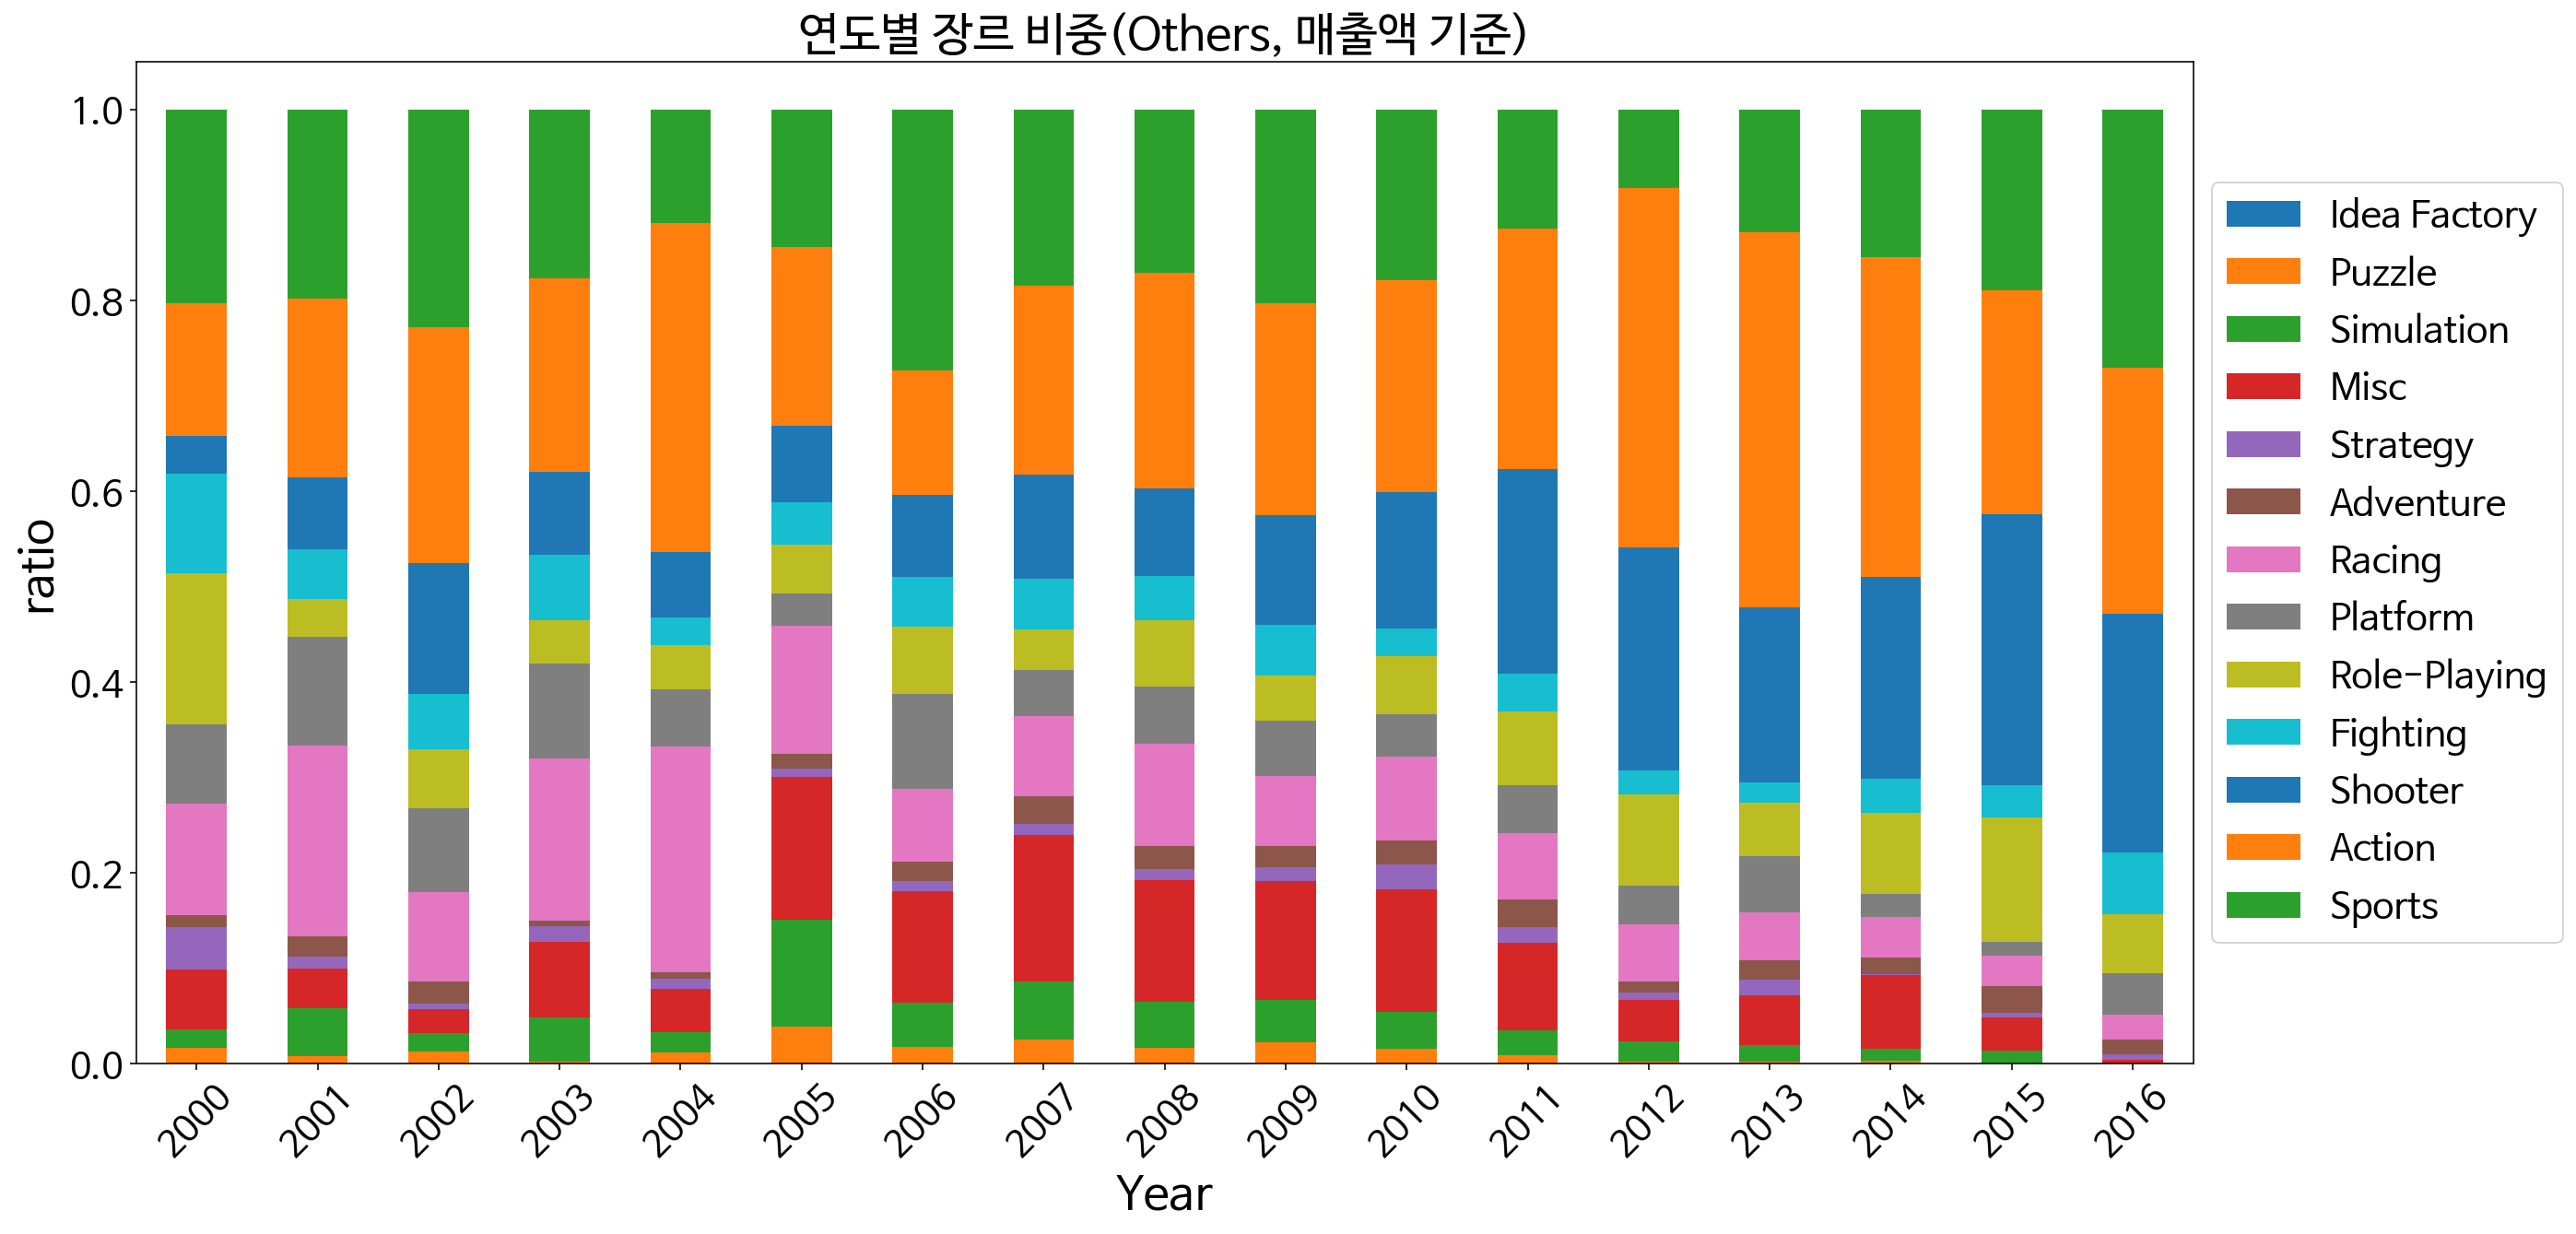

In [69]:
# --------------------------------------------------------
#
# ㅇ 목표2: 게임 종류(Genre)
#  - (그래프1/필수) 연도별 게임의 트렌드 변화
#   == 최근 5년간 장르별 총 매출액 변화(가로 막대 비율 그래프)
#
# --------------------------------------------------------
# 2-1. 표 만들기
temp_NA = df_new.groupby(['Year','Genre']).NA_Sales.sum().reset_index()
temp_EU = df_new.groupby(['Year','Genre']).EU_Sales.sum().reset_index()
temp_JP = df_new.groupby(['Year','Genre']).JP_Sales.sum().reset_index()
temp_OT = df_new.groupby(['Year','Genre']).Other_Sales.sum().reset_index()

sales_list = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
table_list = [temp_NA, temp_EU, temp_JP, temp_OT]

def make_table(table_list, sales_list):

    table_list_length = len(table_list)
    table_dict = dict()
    for i in range(table_list_length):
        table = pd.pivot(table_list[i], values = sales_list[i], index='Year', columns='Genre')
        table = table.reset_index().fillna(0)
        table = table[(table['Year']>=2000) & (table['Year'] < 2017)].reset_index(drop=True).drop('99',1)
        table = table.set_index('Year')
        table['total'] = table.sum(axis=1)
        table = table.reset_index()
        table_dict[i] = table
    
    return table_dict

result_table = make_table(table_list, sales_list) # {1: NA, 2: EU, 3: JP, 4: Other}

def make_percentage(dictionary):
    
    table_dict = dict()
    table_rank_dict = dict()
    for j in range(len(dictionary)):
        dictionary[j] = dictionary[j].set_index('Year').fillna(0)
        
        for k in range(len(dictionary[j])):
            dictionary[j].iloc[k] =  dictionary[j].iloc[k] / dictionary[j]['total'].iloc[k]
        # table_dict[j] = dictionary[j].fillna(0).reset_index().drop(['total','Sony Computer Entertainment'], axis = 1)
        # table_rank_dict[j] = dictionary[j].fillna(0).drop(['total','Sony Computer Entertainment'], axis = 1).rank(ascending = False, axis = 1)    
        dictionary[j] = dictionary[j].fillna(0).drop(['total','Sony Computer Entertainment'], axis = 1).sort_values(axis = 1, by = 2016).reset_index()
        dictionary[j]['Year'] = dictionary[j]['Year'].astype(int)
        table_rank_dict[j] = dictionary[j]

    return table_rank_dict
        
result_percentage = make_percentage(result_table)

# 2-2. 그래프 제작하기
def draw_graph(dict, title_list):

    for h in range(len(dict)):

        dict[h].plot(
        x = 'Year',
        kind = 'bar',
        stacked = True,
        figsize = [20,10]
    )
        plt.xlabel('Year', fontsize = 25)
        plt.ylabel('ratio', fontsize = 25)
        plt.xticks(fontsize = 20, rotation = 45)
        plt.yticks(fontsize = 20)
        plt.title(title_list[h], fontsize = 25)

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
        plt.show()

        
title_list = ['연도별 장르 비중(NA, 매출액 기준)',
              '연도별 장르 비중(EU, 매출액 기준)',
              '연도별 장르 비중(JP, 매출액 기준)',
              '연도별 장르 비중(Others, 매출액 기준)',]
graph = draw_graph(result_percentage, title_list)
graph

        Year Platform         Genre  Name
0        0.0     2600        Action     6
1        0.0     2600     Adventure     1
2        0.0     2600      Fighting     1
3        0.0     2600        Puzzle     3
4        0.0     2600        Racing     2
...      ...      ...           ...   ...
1654  2016.0     XBox        Sports    13
1655  2016.0     XBox      Strategy     1
1656  2017.0       PS        Action     1
1657  2017.0       PS  Role-Playing     2
1658  2020.0       DS    Simulation     1

[1659 rows x 4 columns]


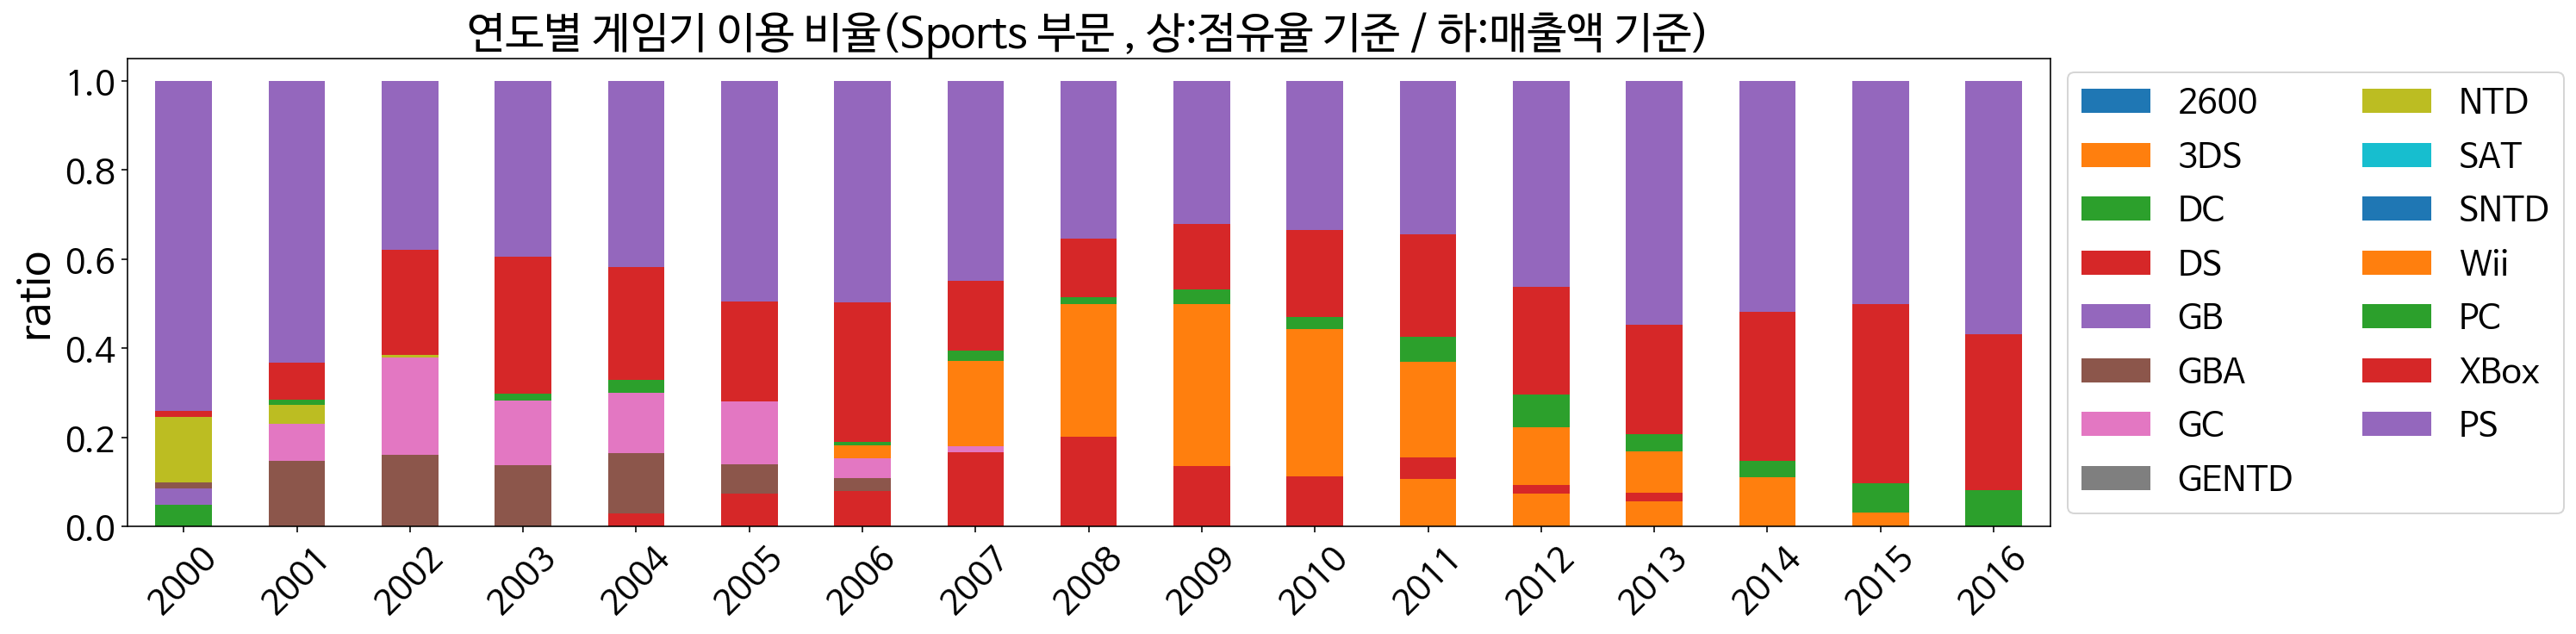

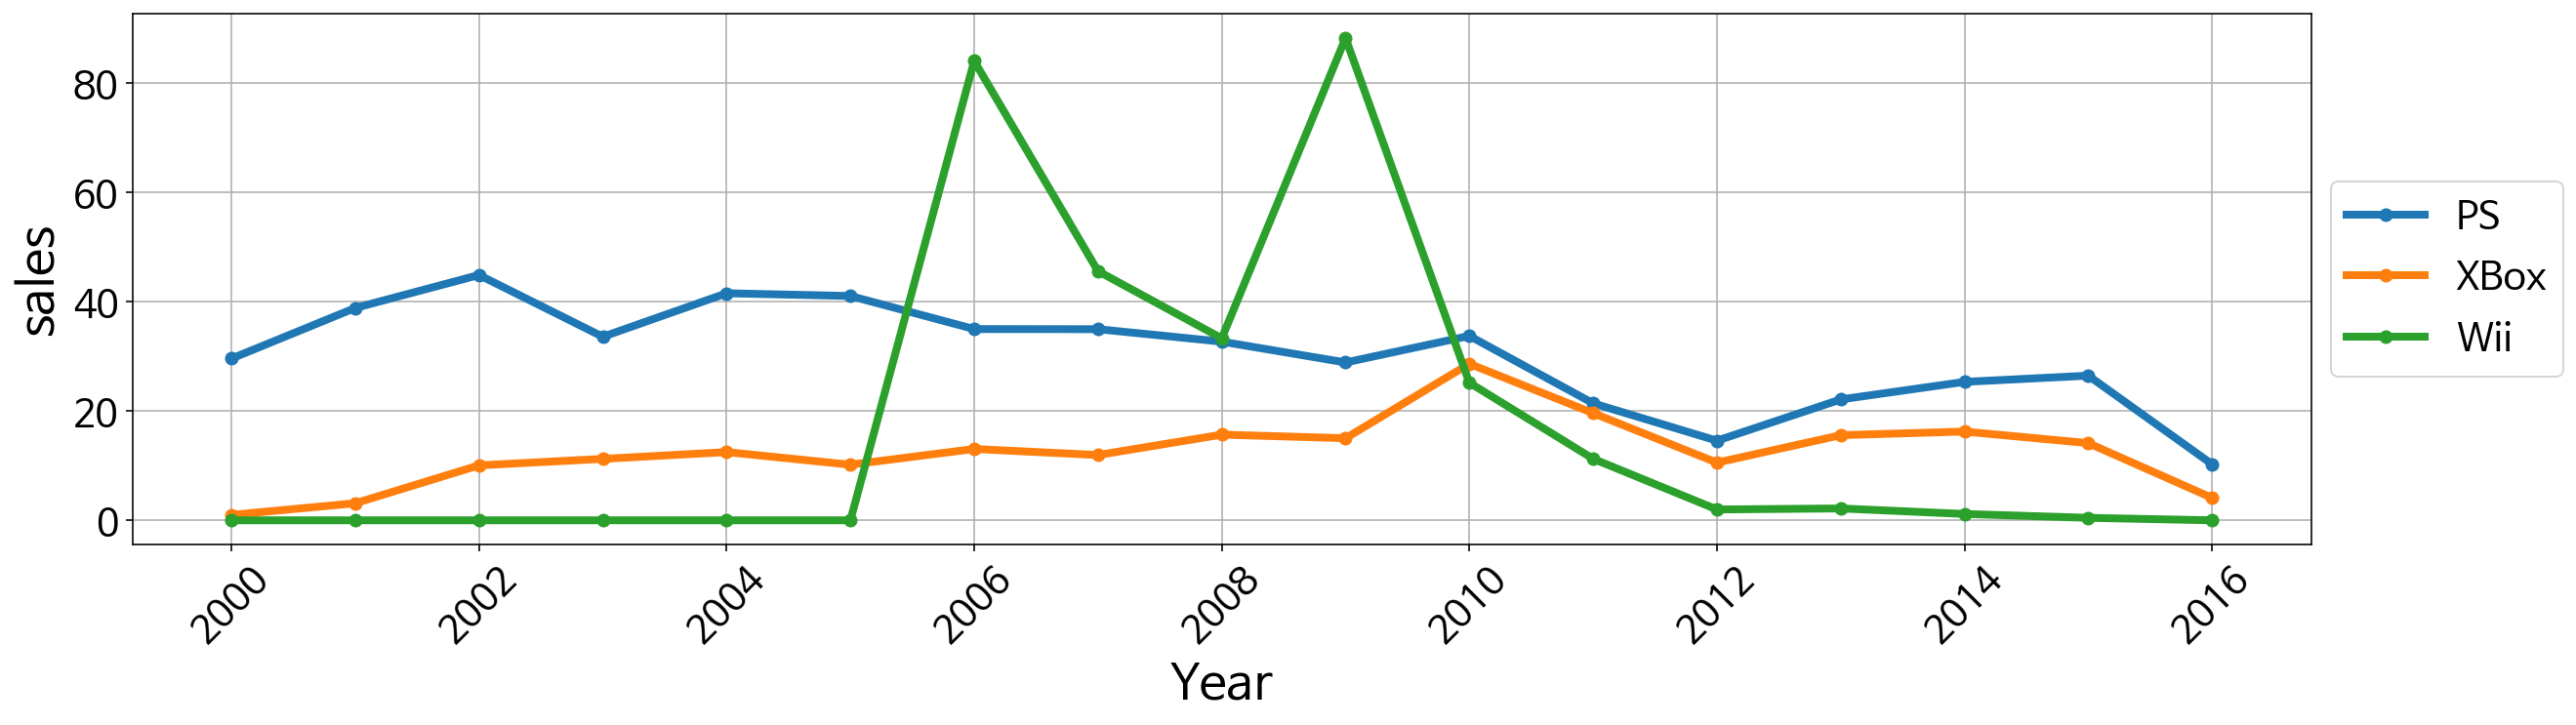

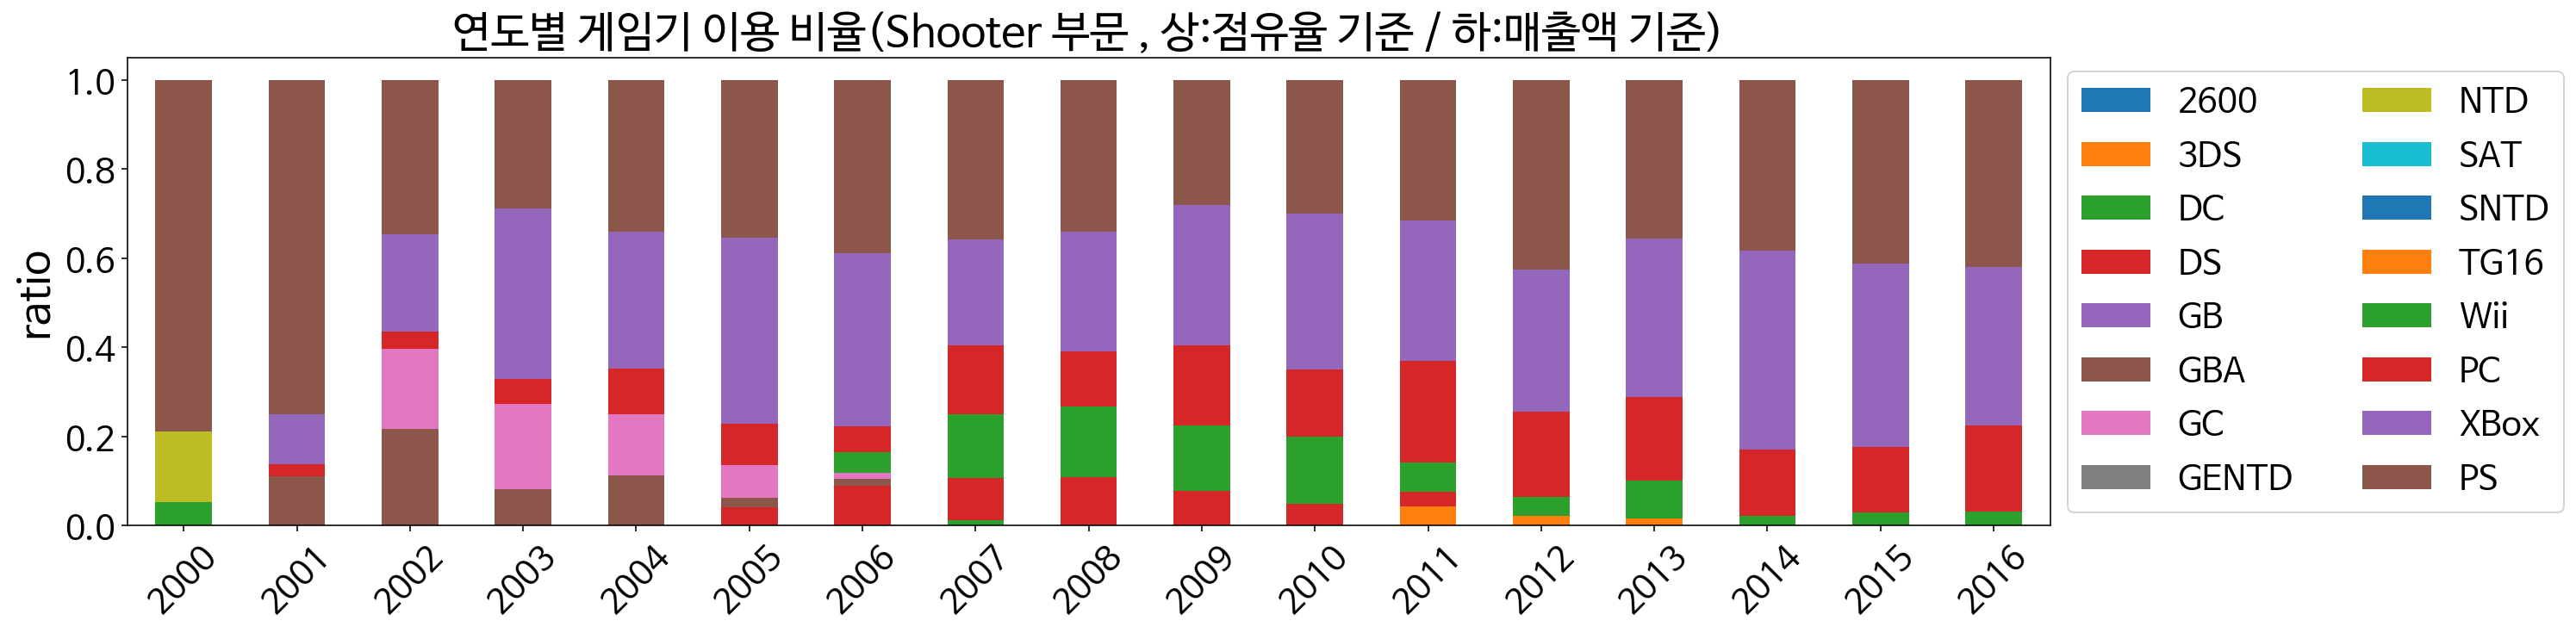

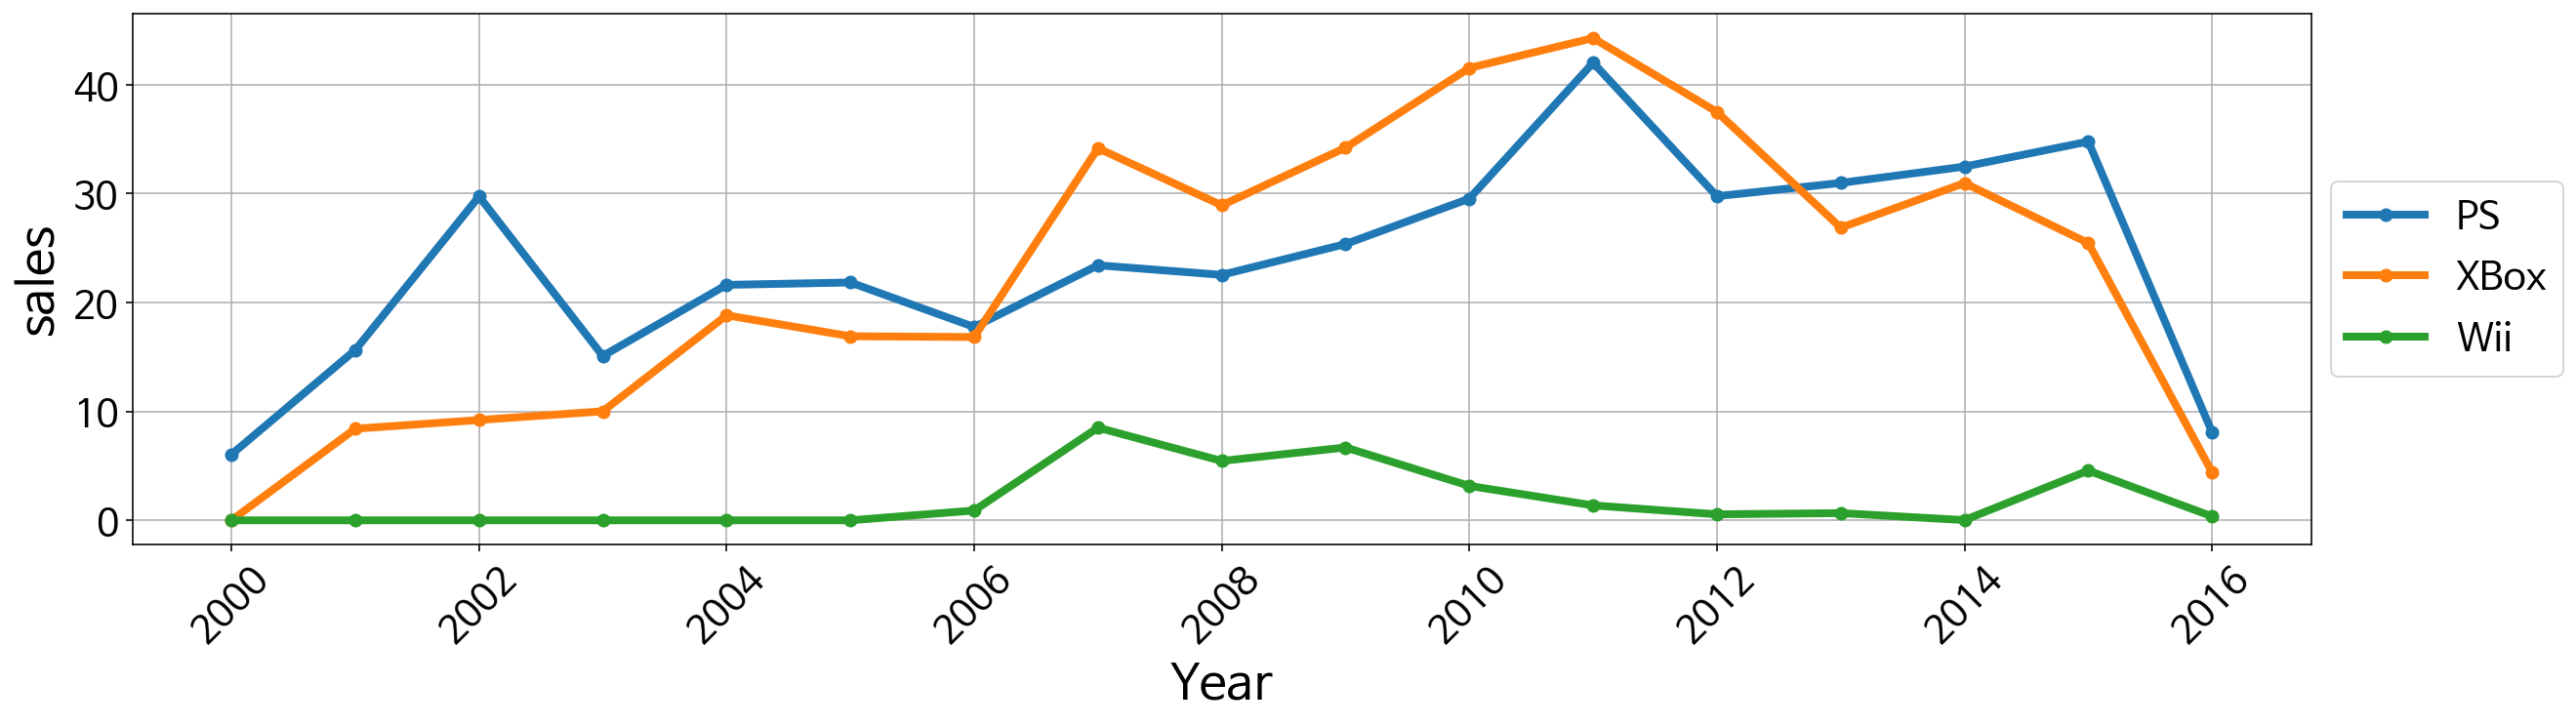

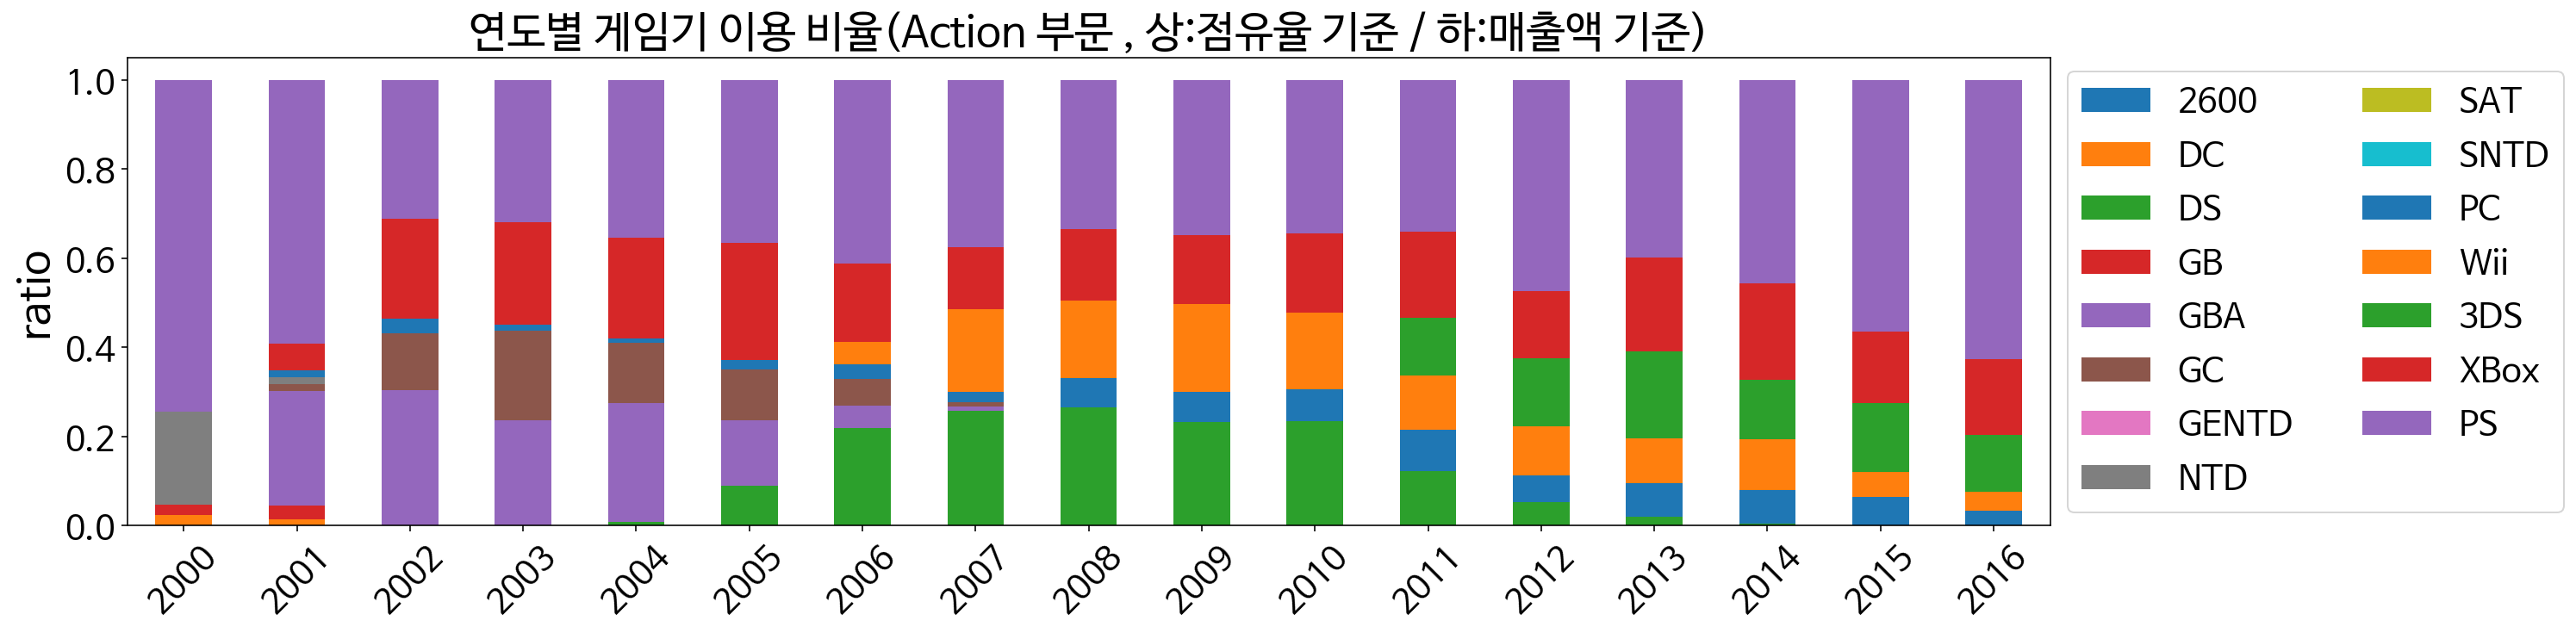

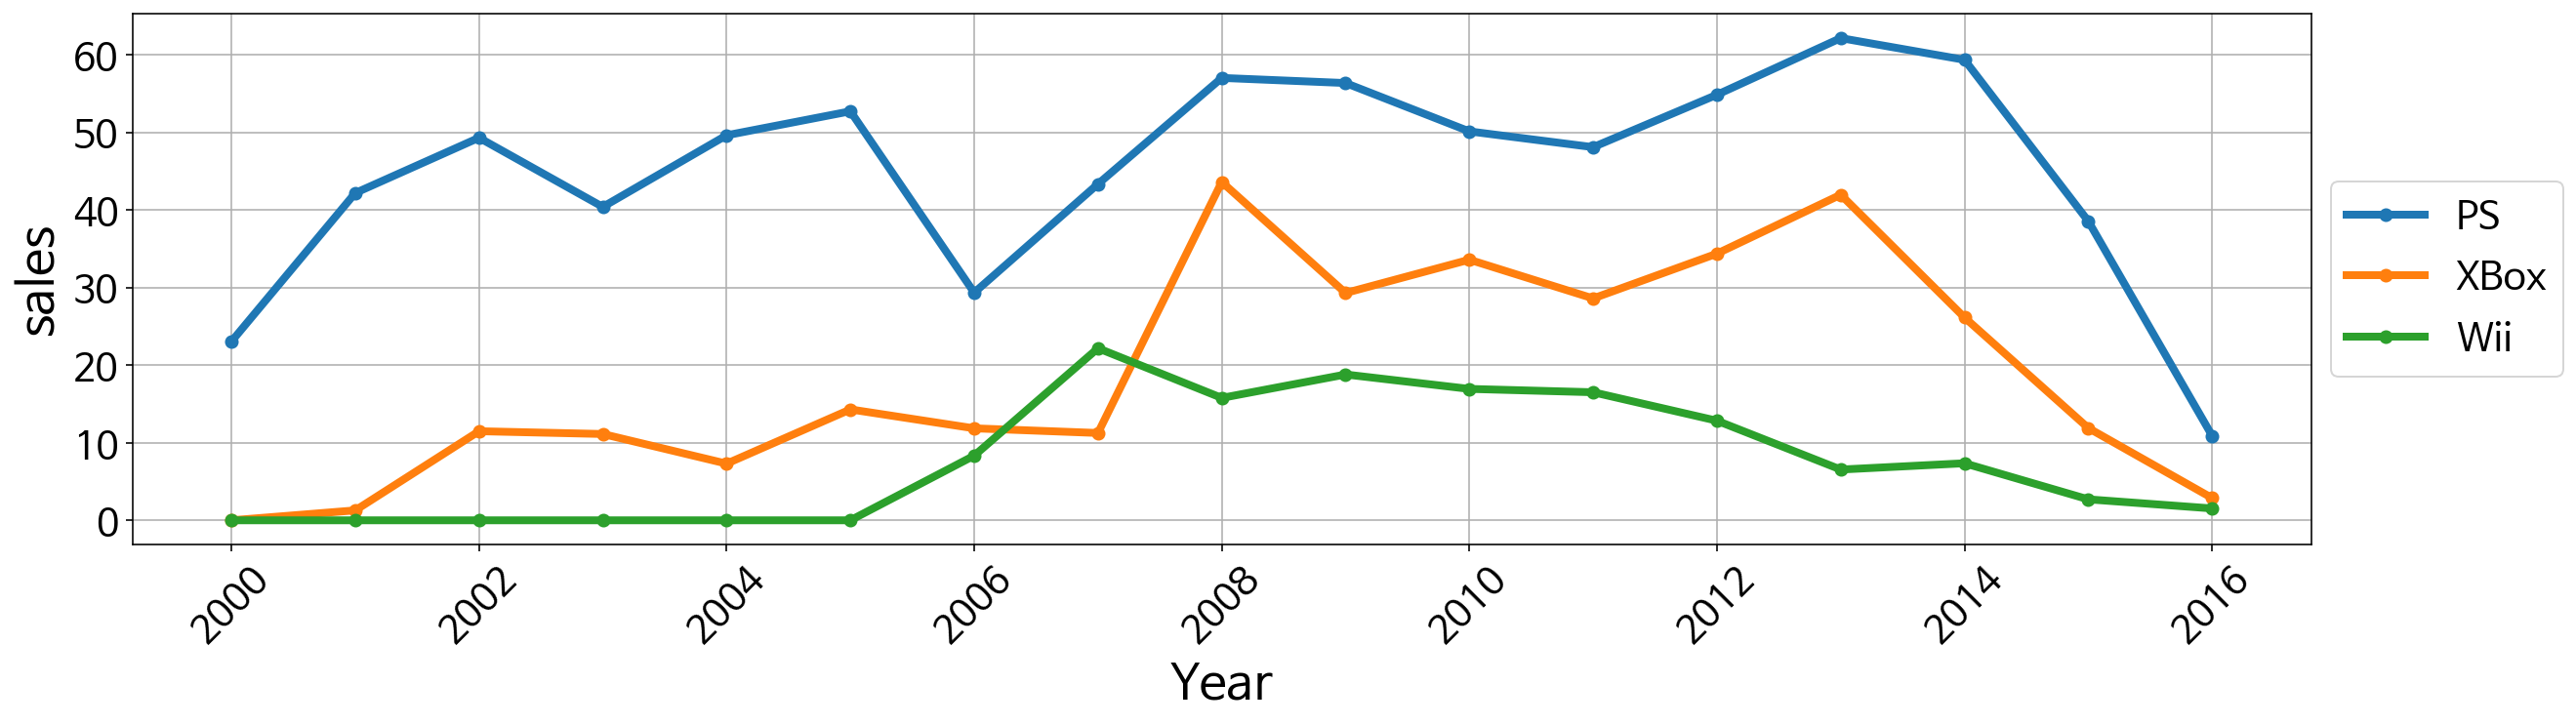

In [70]:
# --------------------------------------------------------
#
# ㅇ 목표3: platform 종류
#  - (그래프1/필수) 매출이 높은 게임에 대한 분석
#   == 최근 5년간 platform별 총 매출액 변화 그래프화
#
# --------------------------------------------------------
# 3-1. 분석 게임 종류(Genre, 2016년 기준, 4개 지역 공통 top3)
# 분석 대상: Action, Sports, Shooter

# 3-2. 표 제작하기
# 3-2-1. 장르별, 연도별 Platform 개수

# 계열 합치기
df_new_temp = df_new
df_new_temp['Platform']= df_new_temp['Platform'].str.replace('PS(.*)','PS').replace('GB(.*)','GB').replace('PC(.*)','PC').str.replace('N(.*)','NTD').str.replace('W(.*)','Wii').str.replace('X(.*)','XBox')
temp = df_new_temp.groupby(['Year','Platform','Genre']).Name.count().reset_index()
top_3_list = ['Sports', 'Shooter', 'Action']
print(temp)

def make_table_genre_1(df, genre_list):

    genre_list_length = len(genre_list)
    table_genre_top_3_list = list()
    for index in range(genre_list_length):
        temp_table = df[df['Genre'] == genre_list[index]]
        table_genre_top_3_list.append(temp_table)
    
    return table_genre_top_3_list

result_table_groupby_genre_1 = make_table_genre_1(temp, top_3_list)


 # 장르별 게임기 개수 구하기 
def make_table_platform_1(table_list):

    table_list_length = len(table_list)
    table_dict = dict()
    for i in range(table_list_length):
        table = pd.pivot(table_list[i], values = 'Name', index='Year', columns='Platform')
        table = table.reset_index().fillna(0)
        table = table[(table['Year']>=2000) & (table['Year'] < 2017)].reset_index(drop=True)
        table = table.set_index('Year')
        table['total'] = table.sum(axis=1)
        table = table.reset_index()
        table_dict[i] = table
    return table_dict

result_table_dict_1 = make_table_platform_1(result_table_groupby_genre_1) # {1: Sports, 2: Shooter, 3: Action} # 개수


 # 게임기의 개수 비율(=점유율) 구하기
def make_percentage_platform_1(dictionary):  
    
    table_dict = dict()
    table_rank_dict = dict()
    table_platform_percentage_dict = dict()
    for j in range(len(dictionary)):
        dictionary[j] = dictionary[j].set_index('Year').fillna(0)
        
        for k in range(len(dictionary[j])):
            dictionary[j].iloc[k] =  dictionary[j].iloc[k] / dictionary[j]['total'].iloc[k]
        
        dictionary[j] = dictionary[j].fillna(0).drop('total', axis = 1).sort_values(axis = 1, by = 2016).reset_index()
        dictionary[j]['Year'] = dictionary[j]['Year'].astype(int) 
        table_platform_percentage_dict[j] = dictionary[j]
        
    return table_platform_percentage_dict
        
result_percentage_1 = make_percentage_platform_1(result_table_dict_1)


# 3-2-2. 장르별, 연도별 Platform별 매출액
temp = df_new_temp.groupby(['Year','Platform','Genre']).sum()
temp = temp.sum(axis = 1).reset_index()
top_3_list = ['Sports', 'Shooter', 'Action']
top_3_platform = ['PS', 'XBox', 'Wii']

def make_table_sales_2(df, genre_list):

    genre_list_length = len(genre_list)
    table_genre_top_3_list = list()
    for index in range(genre_list_length):
        temp_table = df[df['Genre'] == genre_list[index]]
        table_genre_top_3_list.append(temp_table)
    
    return table_genre_top_3_list

result_table_groupby_genre_2 = make_table_sales_2(temp, top_3_list)
result_table_groupby_genre_2[0]
def make_table_platform_2(table_list, top_3_platform):

    table_list_length = len(table_list)
    table_dict = dict()
    for i in range(table_list_length):
        table = pd.pivot(table_list[i], values = 0, index='Year', columns='Platform')
        table = table.reset_index().fillna(0)
        table = table[(table['Year']>=2000) & (table['Year'] < 2017)].reset_index(drop=True)
        table = table.set_index('Year')
        table_dict[i] = table[top_3_platform].reset_index()
    
    return table_dict

result_table_dict_2 = make_table_platform_2(result_table_groupby_genre_2, top_3_platform) # {1: Sports, 2: Shooter, 3: Action}


# 3-3. 표 제작하기
def draw_platform_graph_2(dict_1, dict_2, title_list):
    
    for h in range(len(dict_1)):
        
        # 점유율
        dict_1[h].plot(
        x = 'Year',
        kind = 'bar',
        stacked = True,
        figsize = [20,5],
        )
        plt.xlabel('', fontsize = 25)
        plt.ylabel('ratio', fontsize = 25)
        plt.xticks(fontsize = 20, rotation = 45)
        plt.yticks(fontsize = 20)
        plt.title(title_list[h], fontsize = 25)

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20, ncol=2)
        plt.show()

        # 매출액
        dict_2[h].plot(
        x = 'Year',
        kind = 'line',
        marker='o',
        linewidth = 4,
        figsize = [20,5]
       )
        plt.grid()
        plt.xlabel('Year', fontsize = 25)
        plt.ylabel('sales', fontsize = 25)
        plt.xticks(fontsize = 20, rotation = 45)
        plt.yticks(fontsize = 20)

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
        plt.show()

title_list = ['연도별 게임기 이용 비율(Sports 부문 , 상:점유율 기준 / 하:매출액 기준)',
              '연도별 게임기 이용 비율(Shooter 부문 , 상:점유율 기준 / 하:매출액 기준)',
              '연도별 게임기 이용 비율(Action 부문 , 상:점유율 기준 / 하:매출액 기준)'
              ]
                        
graph = draw_platform_graph_2(result_percentage_1, result_table_dict_2, title_list)
graph